# Building Gapminder plot using Models

The low-level API that lets you build pieces up individually


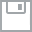
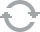
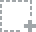
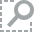
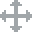
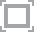
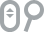
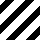
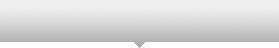
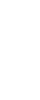
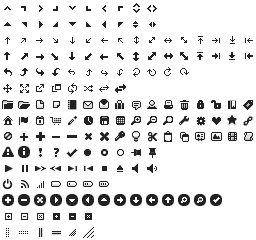
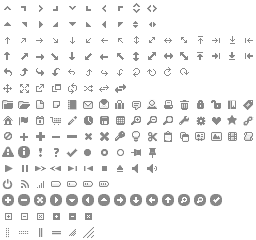
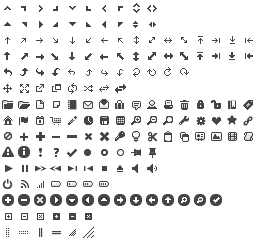
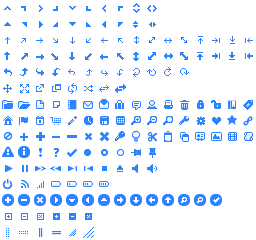
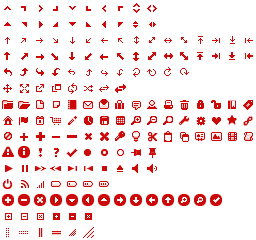
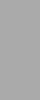
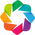
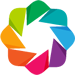

In [1]:
from bokeh.io import output_notebook, show
output_notebook()

In [2]:
from bokeh.models import Range1d, Plot

def get_plot():
    xdr = Range1d(1, 9)
    ydr = Range1d(20, 100)
    plot = Plot(
        x_range=xdr,
        y_range=ydr,
        title="",
        plot_width=800,
        plot_height=400,
        outline_line_color=None,
        toolbar_location=None,
        responsive=True
    )
    return plot
show(get_plot())

ERROR:/Users/caged/miniconda3/envs/strata_tutorial/lib/python3.4/site-packages/bokeh/validation/check.py:W-1000 (MISSING_RENDERERS): Plot has no renderers: Plot, ViewModel:Plot, ref _id: 81e31497-4c10-42fc-99c8-ab4f25a84da1
ERROR:/Users/caged/miniconda3/envs/strata_tutorial/lib/python3.4/site-packages/bokeh/validation/check.py:W-1001 (NO_GLYPH_RENDERERS): Plot has no glyph renderers: Plot, ViewModel:Plot, ref _id: 81e31497-4c10-42fc-99c8-ab4f25a84da1


Note the warnings are expected and useful - they're telling you why you're just seeing a blank box above!

In [3]:
AXIS_FORMATS = dict(
    minor_tick_in=None,
    minor_tick_out=None,
    major_tick_in=None,
    major_label_text_font_size="10pt",
    major_label_text_font_style="normal",
    axis_label_text_font_size="10pt",

    axis_line_color='#AAAAAA',
    major_tick_line_color='#AAAAAA',
    major_label_text_color='#666666',

    major_tick_line_cap="round",
    axis_line_cap="round",
    axis_line_width=1,
    major_tick_line_width=1,
)

In [4]:
from bokeh.models import LinearAxis, SingleIntervalTicker

def add_axes(plot):
    xaxis = LinearAxis(SingleIntervalTicker(interval=1), axis_label="Children per woman (total fertility)", **AXIS_FORMATS)
    yaxis = LinearAxis(SingleIntervalTicker(interval=20), axis_label="Life expectancy at birth (years)", **AXIS_FORMATS)
    plot.add_layout(xaxis, 'below')
    plot.add_layout(yaxis, 'left')
    return plot
show(add_axes(get_plot()))

ERROR:/Users/caged/miniconda3/envs/strata_tutorial/lib/python3.4/site-packages/bokeh/validation/check.py:W-1001 (NO_GLYPH_RENDERERS): Plot has no glyph renderers: Plot, ViewModel:Plot, ref _id: c2647f1e-ce52-4787-921e-f00f0cac8f02


In [5]:
from bokeh.models import ColumnDataSource, Text

text_source = ColumnDataSource({'year': ['1964']})

def add_text(plot):
    plot = add_axes(plot)
    # Add the year in background (add before circle)
    text = Text(x=2, y=35, text='year', text_font_size='150pt', text_color='#EEEEEE')
    plot.add_glyph(text_source, text)
    return plot

show(add_text(get_plot()))

In [6]:
from bokeh.models import Circle, HoverTool
from bokeh.palettes import Spectral6
from utils import get_gapminder_1964_data

renderer_source = ColumnDataSource(get_gapminder_1964_data())

def add_circles(plot):
    plot = add_text(plot)
    # Add the circle
    circle_glyph = Circle(
        x='fertility', y='life', size='population',
        fill_color='region_color', fill_alpha=0.8,
        line_color='#7c7e71', line_width=0.5, line_alpha=0.5)
    circle_renderer = plot.add_glyph(renderer_source, circle_glyph)

    # Add the hover (only against the circle and not other plot elements)
    tooltips = "@index"
    plot.add_tools(HoverTool(tooltips=tooltips, renderers=[circle_renderer]))
    return plot

show(add_circles(get_plot()))

In [7]:
from utils import _process_gapminder_data, get_gapminder_1964_data
fertility_df, life_expectancy_df, population_df_size, regions_df, years, regions = _process_gapminder_data()

In [8]:
def add_legend(plot):
    plot = add_circles(plot)
    # Add a custom legend
    text_x = 7
    text_y = 95
    for i, region in enumerate(regions):
        plot.add_glyph(Text(x=text_x, y=text_y, text=[region], text_font_size='10pt', text_color='#666666'))
        plot.add_glyph(Circle(x=text_x - 0.1, y=text_y + 2, fill_color=Spectral6[i], size=10, line_color=None, fill_alpha=0.8))
        text_y = text_y - 5
    return plot
    
show(add_legend(get_plot()))

# Interaction

In [9]:
import pandas as pd
from bokeh.models import CustomJS, Slider
from bokeh.plotting import vplot
sources = {}

region_color = regions_df['region_color']
region_color.name = 'region_color'

def make_interactive(plot):
    plot = add_legend(plot)
    
    for year in years:
        fertility = fertility_df[year]
        fertility.name = 'fertility'
        life = life_expectancy_df[year]
        life.name = 'life'
        population = population_df_size[year]
        population.name = 'population'
        new_df = pd.concat([fertility, life, population, region_color], axis=1)
        sources['_' + str(year)] = ColumnDataSource(new_df)

    dictionary_of_sources = dict(zip([x for x in years], ['_%s' % x for x in years]))
    js_source_array = str(dictionary_of_sources).replace("'", "")

    # Add the slider
    code = """
        var year = slider.get('value'),
            sources = %s,
            new_source_data = sources[year].get('data');
        renderer_source.set('data', new_source_data);
        renderer_source.trigger('change');
        text_source.set('data', {'year': [String(year)]});
        text_source.trigger('change');
    """ % js_source_array

    callback = CustomJS(args=sources, code=code)
    slider = Slider(start=years[0], end=years[-1], value=1, step=1, title="Year", callback=callback)
    callback.args["slider"] = slider
    callback.args["renderer_source"] = renderer_source
    callback.args["text_source"] = text_source

    
    return vplot(plot, slider)

show(make_interactive(get_plot()))

# Let's break that down a little

### Setting up the data

The plot animates with the slider showing the data over time from 1964 to 2013. We can think of each year as a seperate static plot, and when the slider moves, we use the Callback to change the data source that is driving the plot.

We could use bokeh-server to drive this change, but as the data is not too big we can also pass all the datasets to the javascript at once and switch between them on the client side.

This means that we need to build one data source for each year that we have data for and are going to switch between using the slider. We build them and add them to a dictionary sources that holds them under a key that is the name of the year preficed with a _.

In [10]:
fertility_df, life_expectancy_df, population_df_size, regions_df, years, regions = _process_gapminder_data()

sources = {}

region_color = regions_df['region_color']
region_color.name = 'region_color'

for year in years:
    fertility = fertility_df[year]
    fertility.name = 'fertility'
    life = life_expectancy_df[year]
    life.name = 'life'
    population = population_df_size[year]
    population.name = 'population'
    new_df = pd.concat([fertility, life, population, region_color], axis=1)
    sources['_' + str(year)] = ColumnDataSource(new_df)

In [11]:
print(sources['_1964'])
print(sources['_1965'])
print(sources['_1966'])

ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 255a1414-1e1c-44bc-84fe-81c4b161f956
ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 51b822e4-1e9c-4f93-bd95-1df274505af3
ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 862e4b7f-3d42-44b0-9261-6736e838f24a


We will pass this sources dictionary to the CustomJS. 

In doing so, we will find that in our javascript we have an object called, for example `1964`, that refers to our ColumnDataSource `1964`!!! (I think this is so cool).

Note that we needed the prefixing as JS objects cannot begin with a number.

Finally we construct a string that we can insert into our javascript code to define an object.

The string looks like this: {1962: _1962, 1963: _1963, ....}

Note the keys of this object are integers and the values are the references to our ColumnDataSources from above. So that now, in our JS code, we have an object that's storing all of our ColumnDataSources and we can look them up.

In [12]:
dictionary_of_sources = dict(zip([x for x in years], ['_%s' % x for x in years]))
js_source_array = str(dictionary_of_sources).replace("'", "")

Last, but not least, we add the slider widget and the JS callback code which changes the data of the renderer_source (powering the bubbles / circles) and the data of the text_source (powering background text). After we've set() the data we need to trigger() a change. slider, renderer_source, text_source are all available because we add them as args to Callback.

It is the combination of `"""sources = %s """ % js_source_array` in the `code` and `CustomJS(args=sources...)` that provides the ability to look-up, by year, the JS version of our python-made ColumnDataSource.

In [13]:
# Add the slider
code = """
    var year = slider.get('value'),
        sources = %s,
        new_source_data = sources[year].get('data');
    renderer_source.set('data', new_source_data);
    renderer_source.trigger('change');
    text_source.set('data', {'year': [String(year)]});
    text_source.trigger('change');
""" % js_source_array

callback = CustomJS(args=sources, code=code)
slider = Slider(start=years[0], end=years[-1], value=1, step=1, title="Year", callback=callback)
callback.args["slider"] = slider
callback.args["renderer_source"] = renderer_source
callback.args["text_source"] = text_source

# Embedding

* ipython - output_notebook() & show
 * works on [nbviewer](nbviewer.ipython.org) and [anaconda viewer](https://notebooks.anaconda.org/)
 * Does not work on github notebook viewer - you'll be able to see your code but not your bokeh plots.
 
* file - output_file() & show / save

* embed functions - file_html, components, ...
* understand Resources - CDN, INLINE, other...

In [14]:
from jinja2 import Template
from bokeh.templates import JS_RESOURCES
from bokeh.resources import Resources
from bokeh.embed import components

with open('assets/gapminder_template.jinja', 'r') as f:
    template = Template(f.read())

resources = Resources(mode='server', root_url='tree/')

bokeh_js = JS_RESOURCES.render(js_files=resources.js_files)
script, div = components(make_interactive(get_plot()))
html = template.render(
    title="Bokeh - Gapminder demo",
    bokeh_js=bokeh_js,
    plot_script=script,
    plot_div=div,
)

In [15]:
from IPython.display import display, HTML
display(HTML(html))